In [ ]:
!pip install optuna --quiet

In [45]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim as optim

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:",device)

using device: cuda


In [47]:
df_train = pd.read_csv("/content/fashion-mnist_train.csv")
print("Shape :",df_train.shape)
df_train.head()

Shape : (60000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df_test = pd.read_csv("/content/fashion-mnist_test.csv")
print("Shape :",df_test.shape)
df_test.head()

Shape : (10000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


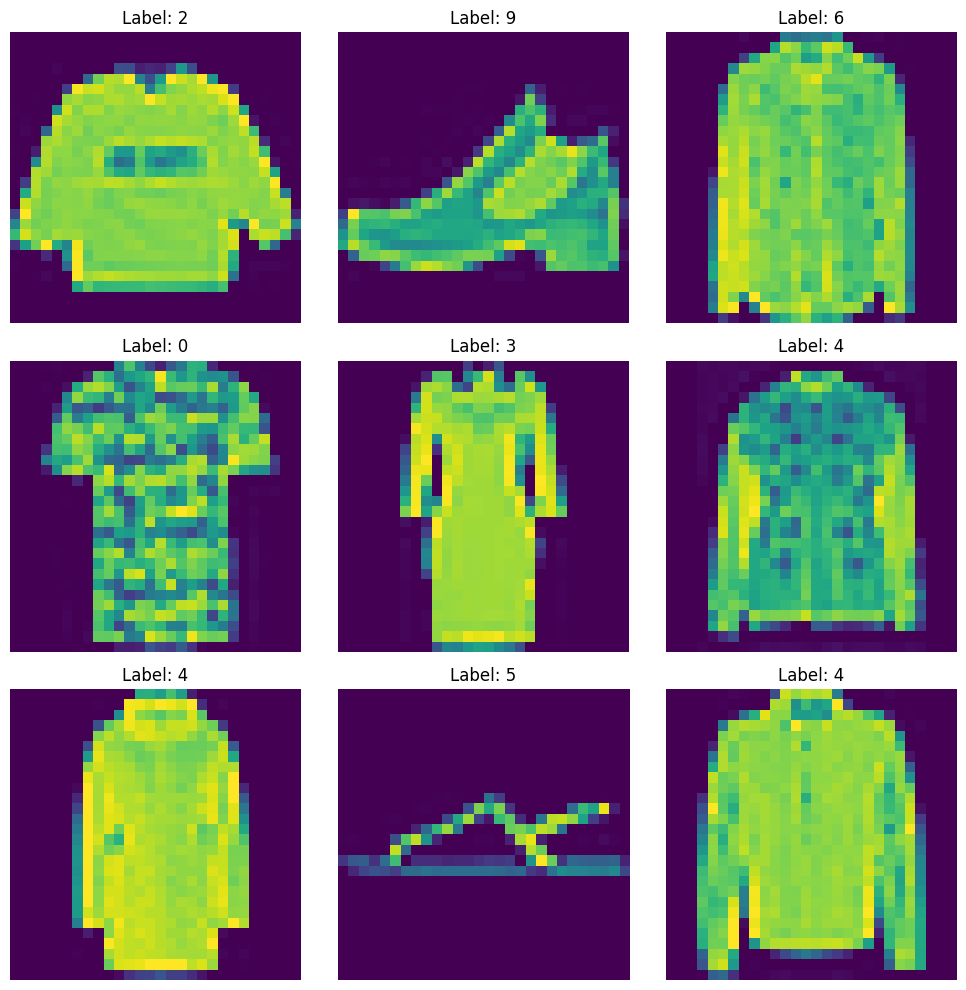

In [49]:
fig, axes = plt.subplots(3,3, figsize=(10,10))

for i, ax in enumerate(axes.flat):
    img = df_train.iloc[i , 1:].values.reshape(28, 28)
    ax.imshow(img)
    ax.set_title(f"Label: {df_train.iloc[i, 0]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [51]:
X_train = df_train.iloc[:, 1:].values
y_train = df_train.iloc[:, 0].values

X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

X_train = X_train / 255.0
X_test = X_test / 255.0

In [52]:
class CustromDataset(Dataset):

    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype= torch.float32)
        self.y = torch.tensor(y, dtype= torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_dataset = CustromDataset(X_train, y_train)
test_dataset = CustromDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)  # Increase the batch size and set the pin memory to True
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

len(train_loader), len(test_loader)  # No of Batches

(469, 79)

# **Hyper Parameter Tuning (Optuna)**

In [57]:
class MyNN(nn.Module):

  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):

    super().__init__()

    layers = []

    for i in range(num_hidden_layers):

      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer, output_dim))

    self.model = nn.Sequential(*layers)

  def forward(self, x):

    return self.model(x)

In [58]:
# objective function
def objective(trial):

  # next hyperparameter values from the search space
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
  epochs = trial.suggest_int("epochs", 10, 50, step=10)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
  batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
  optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

  # model init
  input_dim = 784
  output_dim = 10

  model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)

  # optimizer selection
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

  if optimizer_name == 'Adam':
    optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'SGD':
    optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # training loop

  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward pass
      outputs = model(batch_features)

      # calculate loss
      loss = criterion(outputs, batch_labels)

      # back pass
      optimizer.zero_grad()
      loss.backward()

      # update grads
      optimizer.step()


  # evaluation
  model.eval()
  # evaluation on test data
  total = 0
  correct = 0

  with torch.no_grad():

    for batch_features, batch_labels in test_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      outputs = model(batch_features)

      _, predicted = torch.max(outputs, 1)

      total = total + batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total

  return accuracy

In [59]:
import optuna

study = optuna.create_study(direction="maximize")

[I 2025-06-16 07:28:22,901] A new study created in memory with name: no-name-de66e024-9ef3-4b9c-8557-5b073693d3c5


In [60]:
study.optimize(objective, n_trials=10)

[I 2025-06-16 07:30:14,007] Trial 0 finished with value: 0.8778 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 120, 'epochs': 30, 'learning_rate': 4.9840711886739415e-05, 'dropout_rate': 0.5, 'batch_size': 64, 'optimizer': 'Adam', 'weight_decay': 2.2098335927401318e-05}. Best is trial 0 with value: 0.8778.
[I 2025-06-16 07:32:47,670] Trial 1 finished with value: 0.8859 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 104, 'epochs': 30, 'learning_rate': 0.04100802058893323, 'dropout_rate': 0.4, 'batch_size': 32, 'optimizer': 'SGD', 'weight_decay': 4.913712025270918e-05}. Best is trial 1 with value: 0.8859.
[I 2025-06-16 07:39:35,767] Trial 2 finished with value: 0.8817 and parameters: {'num_hidden_layers': 5, 'neurons_per_layer': 64, 'epochs': 30, 'learning_rate': 1.6547562971039638e-05, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer': 'Adam', 'weight_decay': 2.603745279789039e-05}. Best is trial 1 with value: 0.8859.
[I 2025-06-16 07:40:20,001] Trial 3 fi

In [62]:
study.best_value

0.8922

In [64]:
study.best_params

{'num_hidden_layers': 2,
 'neurons_per_layer': 104,
 'epochs': 10,
 'learning_rate': 0.0014385362472632425,
 'dropout_rate': 0.2,
 'batch_size': 32,
 'optimizer': 'Adam',
 'weight_decay': 0.00035561426129684877}